In [2]:
# git clone co-tracker from Mara levy's fork
# checkout their commit: git checkout 02..
# pip install -e . 
# !pip install opencv-python matplotlib moviepy flow_vis


# inline changes to codebase
%load_ext autoreload
%autoreload 2


%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
from IPython.display import Image, display
import numpy as np
import torch

1065


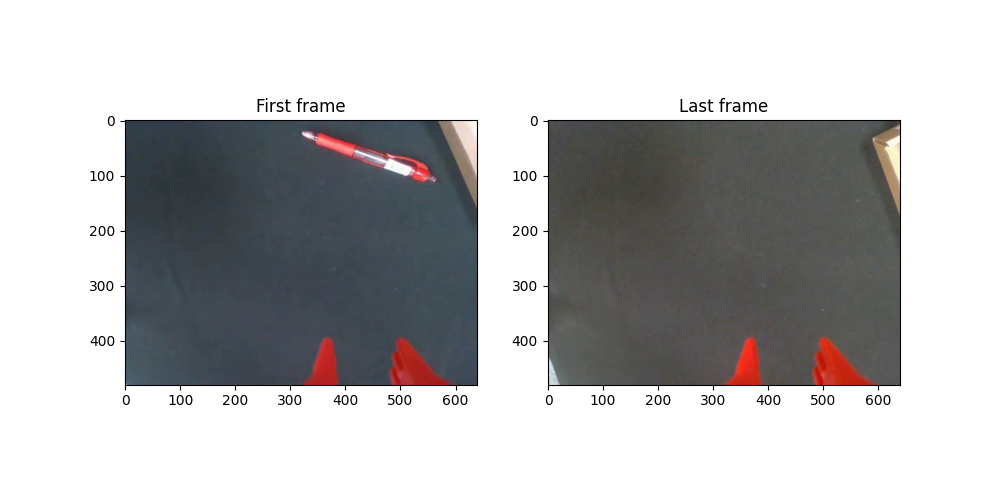

In [3]:
# get video 
# Download the video
url = 'https://github.com/facebookresearch/co-tracker/raw/refs/heads/main/assets/apple.mp4'
url = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/back_camera/data.mp4"
url = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/right_camera/data.mp4"

import imageio.v3 as iio
frames = iio.imread(url, plugin="FFMPEG")  # plugin="pyav"
# frames = frames[-1100:-800]
print(len(frames))

# visualize first and last frame
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(frames[0])
ax[0].set_title("First frame")
ax[1].imshow(frames[-1])
ax[1].set_title("Last frame")
plt.show()

# run cotracker

In [4]:
color_list = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']

def click_callback(img_coords, ax, fig):
    def onclick(event):
        """
        This function is called when you click on the image.
        It appends the (x, y) coordinates to the 'coords' list.
        """
        # event.xdata and event.ydata are the floating point coordinates of the click
        if event.xdata is not None and event.ydata is not None:
            ix, iy = int(event.xdata), int(event.ydata)
            print(f'Clicked at x={ix}, y={iy}')
            img_coords.append((ix, iy))
            ax.scatter(ix, iy, c=color_list[len(img_coords) % len(color_list)], s=50)
            fig.canvas.draw()
    return onclick




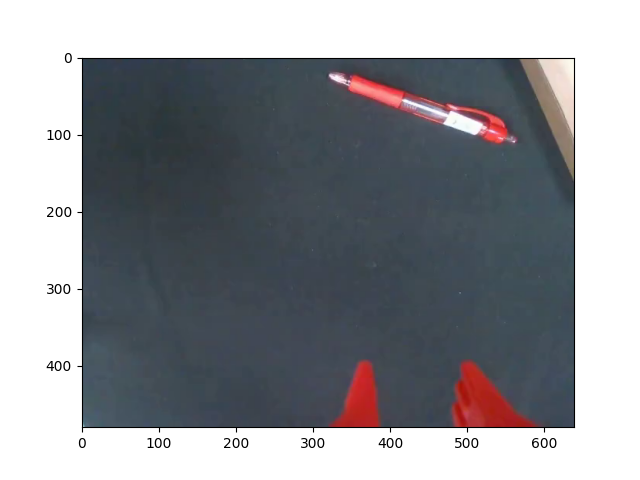

In [5]:

img_coords_1 = []
img = np.array(frames[0])


# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Connect the 'button_press_event' to the 'onclick' function
cid = fig.canvas.mpl_connect('button_press_event', click_callback(img_coords_1, ax, fig))

# Show the plot
plt.show()

In [5]:
raise ValueError("click on points")

ValueError: click on points

In [6]:
print(f"tracking {len(img_coords_1)} points")

# format for co-tracker


# format as tensor with (N,3) shape (x,y,frame_idx )

points = [(0.,kp[0], kp[1]) for kp in img_coords_1]
points = torch.tensor(points)
print(points.shape)

print(points)






tracking 5 points
torch.Size([5, 3])
tensor([[  0., 323.,  23.],
        [  0., 368.,  41.],
        [  0., 428.,  58.],
        [  0., 485.,  81.],
        [  0., 561., 100.]])


In [7]:

import torch


device = 'cuda'
grid_size = 10
video = frames
video = torch.tensor(video).permute(0, 3, 1, 2)[None].float().to(device)  # B T C H W
# only take first 30    frames
print(video.shape)
query_points = points.unsqueeze(0).to(device)


torch.Size([1, 1065, 3, 480, 640])


In [8]:
# Run Offline CoTracker:
# only works on short videoclips due to memory constraints, and was also trained only on clips of about 30s.. 


# offline_tracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)
# # automatically uses local support grid around query points.
# pred_tracks, pred_visibility = offline_tracker(video, queries=query_points) # B T N 2,  B T N 1

# pred_tracks_np = pred_tracks.cpu().numpy().squeeze(0)
# pred_visibility_np = pred_visibility.cpu().numpy().squeeze(0)

# print(pred_tracks_np.shape)








In [9]:
# run online cotracker
from cv2 import TrackerGOTURN
from cotracker.predictor import CoTrackerOnlinePredictor

# load the checkp
#!wget wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_online.pth

root_dir = "."
tracker = CoTrackerOnlinePredictor("scaled_online.pth", window_len=16).to(device)


all_tracks  = []
all_visibilities = []
for frame_idx in range(0, video.shape[1]):
    print(f"frame_idx: {frame_idx}")
    window_frames = video[:,:frame_idx+1,...]
    while window_frames.shape[1] < 16:
        # concatenate the frame 
        window_frames = torch.cat([window_frames, window_frames[:,0,...].unsqueeze(1)], dim=1)
    if window_frames.shape[1] > 16:
        window_frames = window_frames[:,-16:,...]

    if frame_idx == 0:
        tracks, vis = tracker(video_chunk=window_frames,is_first_step=True,add_support_grid=False,queries=query_points)
    tracks, vis = tracker(video_chunk=window_frames,one_frame=True)
    # only keep the last timestep
    all_tracks.append(tracks[:,-1,...].squeeze(0).cpu().numpy())
    all_visibilities.append(vis[:,-1,...].squeeze(0).cpu().numpy())
    
# convert to numpy
all_tracks = np.array(all_tracks)
all_visibilities = np.array(all_visibilities)
print(all_tracks.shape)
print(all_visibilities.shape)
pred_tracks_np = all_tracks
pred_visibility_np = all_visibilities

pred_tracks = torch.tensor(pred_tracks_np).unsqueeze(0)
pred_visibility = torch.tensor(pred_visibility_np).unsqueeze(0)

print(pred_tracks.shape)
print(pred_visibility.shape)



frame_idx: 0
frame_idx: 1
frame_idx: 2
frame_idx: 3
frame_idx: 4
frame_idx: 5
frame_idx: 6
frame_idx: 7
frame_idx: 8
frame_idx: 9
frame_idx: 10
frame_idx: 11
frame_idx: 12
frame_idx: 13
frame_idx: 14
frame_idx: 15
frame_idx: 16
frame_idx: 17
frame_idx: 18
frame_idx: 19
frame_idx: 20
frame_idx: 21
frame_idx: 22
frame_idx: 23
frame_idx: 24
frame_idx: 25
frame_idx: 26
frame_idx: 27
frame_idx: 28
frame_idx: 29
frame_idx: 30
frame_idx: 31
frame_idx: 32
frame_idx: 33
frame_idx: 34
frame_idx: 35
frame_idx: 36
frame_idx: 37
frame_idx: 38
frame_idx: 39
frame_idx: 40
frame_idx: 41
frame_idx: 42
frame_idx: 43
frame_idx: 44
frame_idx: 45
frame_idx: 46
frame_idx: 47
frame_idx: 48
frame_idx: 49
frame_idx: 50
frame_idx: 51
frame_idx: 52
frame_idx: 53
frame_idx: 54
frame_idx: 55
frame_idx: 56
frame_idx: 57
frame_idx: 58
frame_idx: 59
frame_idx: 60
frame_idx: 61
frame_idx: 62
frame_idx: 63
frame_idx: 64
frame_idx: 65
frame_idx: 66
frame_idx: 67
frame_idx: 68
frame_idx: 69
frame_idx: 70
frame_idx: 71
fr

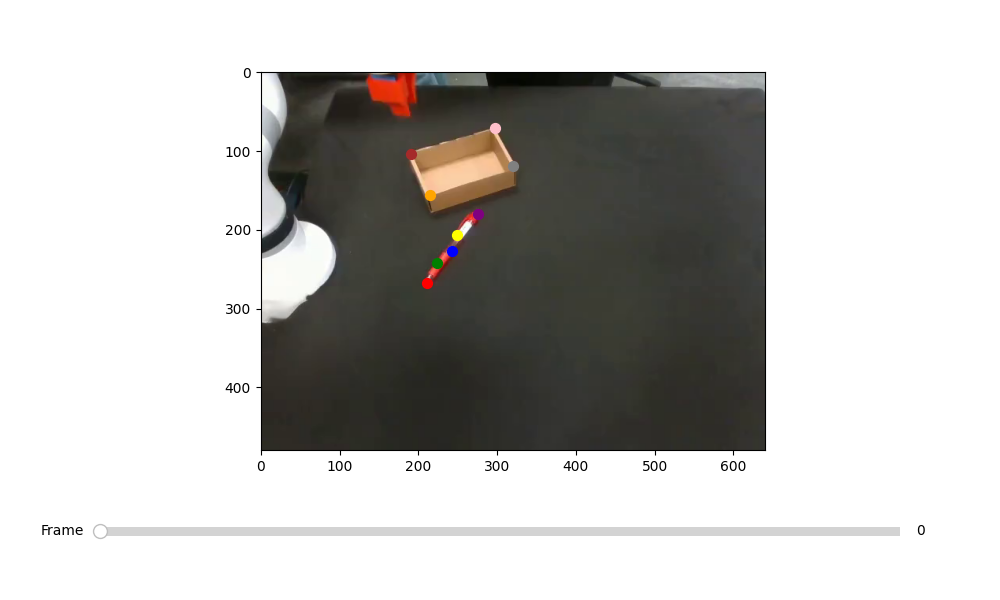

In [10]:
# for each frame, get the tracked points and visualize them using matplotlib interactive mode using a slider to select the frame



# Setup the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(bottom=0.25)
ax.set_title("Video Frame Viewer")


# Initial frame
num_frames = video.shape[1]


# Slider widget
slider_ax = plt.axes([0.1, 0.1, 0.8, 0.03])
slider = widgets.Slider(
    slider_ax, 'Frame', 0, num_frames - 1, valinit=0, valstep=50
)

# Update function
def update(val):
    frame_idx = int(slider.val)
    frame = frames[frame_idx]
    # clear the plot
    ax.clear()
    ax.imshow(frame)
    for point_idx in range(pred_tracks_np[frame_idx].shape[0]):
        color =  color_list[point_idx % len(color_list)]
        ax.scatter(pred_tracks_np[frame_idx][point_idx][0], pred_tracks_np[frame_idx][point_idx][1], color=color,s=50)
    fig.canvas.draw_idle()

# Register the update function with the slider
slider.on_changed(update)

update(0)

plt.show()

In [10]:
from cotracker.utils.visualizer import Visualizer, read_video_from_path
vis = Visualizer(
    save_dir='./videos',
    linewidth=6,
    mode='cool',
    tracks_leave_trace=-1
)

print(video.shape)
print(pred_tracks.shape)
print(pred_visibility.shape)


vis.visualize(
    video=video.cpu(),
    tracks=pred_tracks.cpu(),
    visibility=pred_visibility.cpu(),
    filename='online_2_full_wrist');

torch.Size([1, 1065, 3, 480, 640])
torch.Size([1, 1065, 5, 2])
torch.Size([1, 1065, 5])
Video saved to ./videos/online_2_full_wrist.mp4
